# Reviewing Rainfall Thresholds
The rainfall thresholds used in this notebook look at the intersection between the province boundaries and the 250km radius.

In [20]:
from pathlib import Path
import numpy as np
import pandas as pd
from src import constants
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

In [21]:
rain_df = pd.read_csv(
    Path(constants.AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "daily_imerg_cyclone_landfall_fixed_adm1_v7.csv"
)

In [22]:
threshold = 125

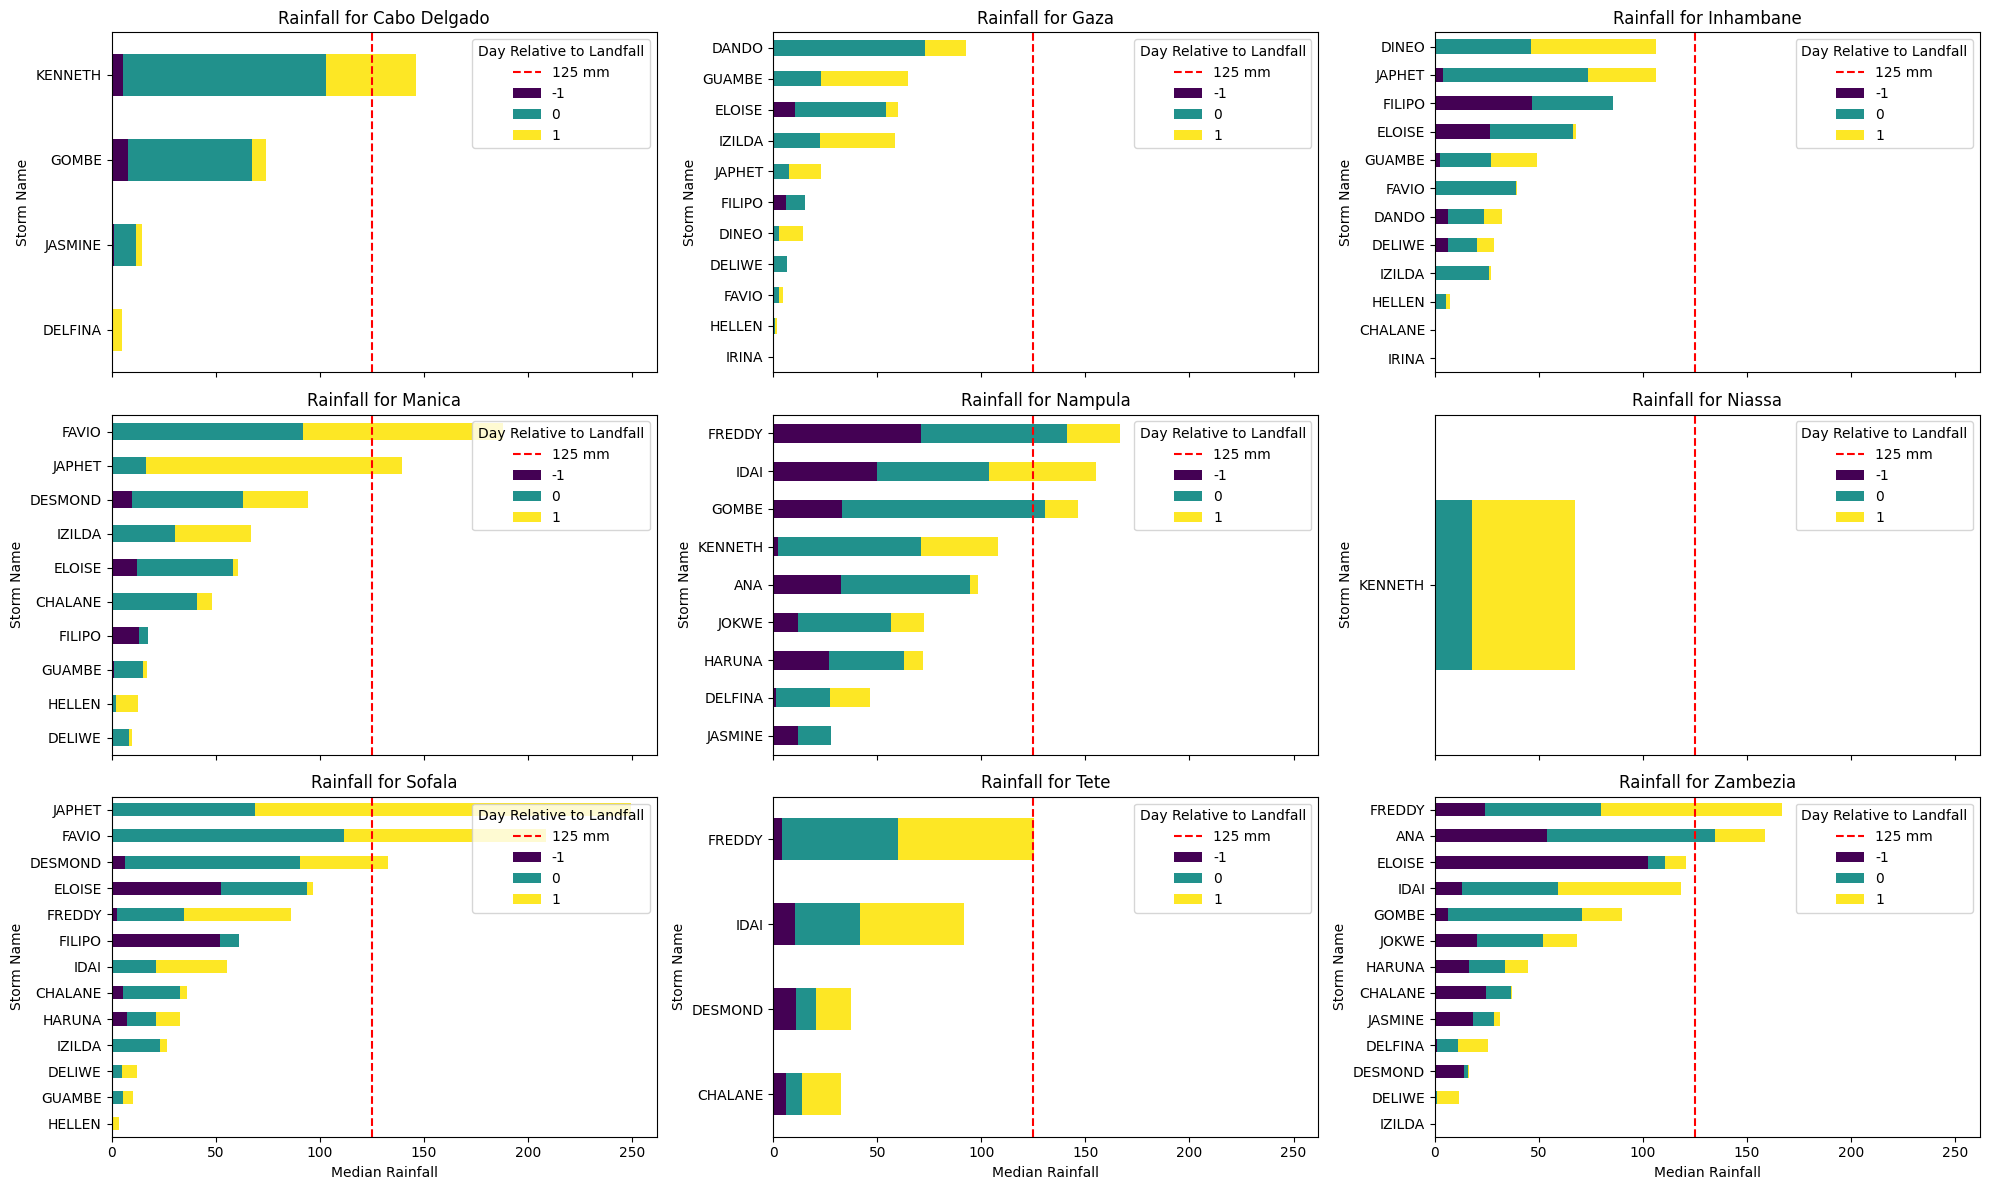

In [23]:
# Filter for specific time steps
df_time_steps = rain_df[rain_df["time_step"].isin([-1, 0, 1])]
df_time_steps["time_step"] = df_time_steps["time_step"].astype(int)

# Filter for radius 250 km
df_filtered = df_time_steps[df_time_steps["radius"] == 250]

# Group the data by province
grouped = df_filtered.groupby("province")

# Determine the number of subplots (1 subplot per province)
num_provinces = len(grouped)
ncols = 3  # Number of columns
nrows = math.ceil(num_provinces / ncols)  # Calculate rows dynamically

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 4 * nrows),  # Adjust figure size for readability
    sharex=True,
)

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate through each province and plot
for ax, (province, group) in zip(axes, grouped):
    # Pivot the data for stacked bar plot for the current province
    df_pivot = group.pivot_table(
        index="storm",
        columns="time_step",
        values="median_precip",
        aggfunc="mean",
    )
    df_pivot.fillna(0, inplace=True)  # Replace NaNs with 0 for missing values

    # Sort storms by total rainfall
    df_pivot["total_rainfall"] = df_pivot.sum(axis=1)
    df_pivot = df_pivot.sort_values(by="total_rainfall", ascending=False)

    # Drop total rainfall column for plotting
    df_pivot.drop(columns="total_rainfall", inplace=True)

    # Plot for the province
    df_pivot.plot(kind="barh", stacked=True, ax=ax, colormap="viridis")

    # Add a vertical line for reference (optional)
    ax.axvline(
        x=threshold, color="red", linestyle="--", label=f"{threshold} mm"
    )

    # Set title and labels
    ax.set_title(f"Rainfall for {province}")
    ax.set_xlabel("Median Rainfall")
    ax.set_ylabel("Storm Name")
    ax.legend(title="Day Relative to Landfall", loc="upper right")

    # Invert y-axis for proper ordering
    ax.invert_yaxis()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

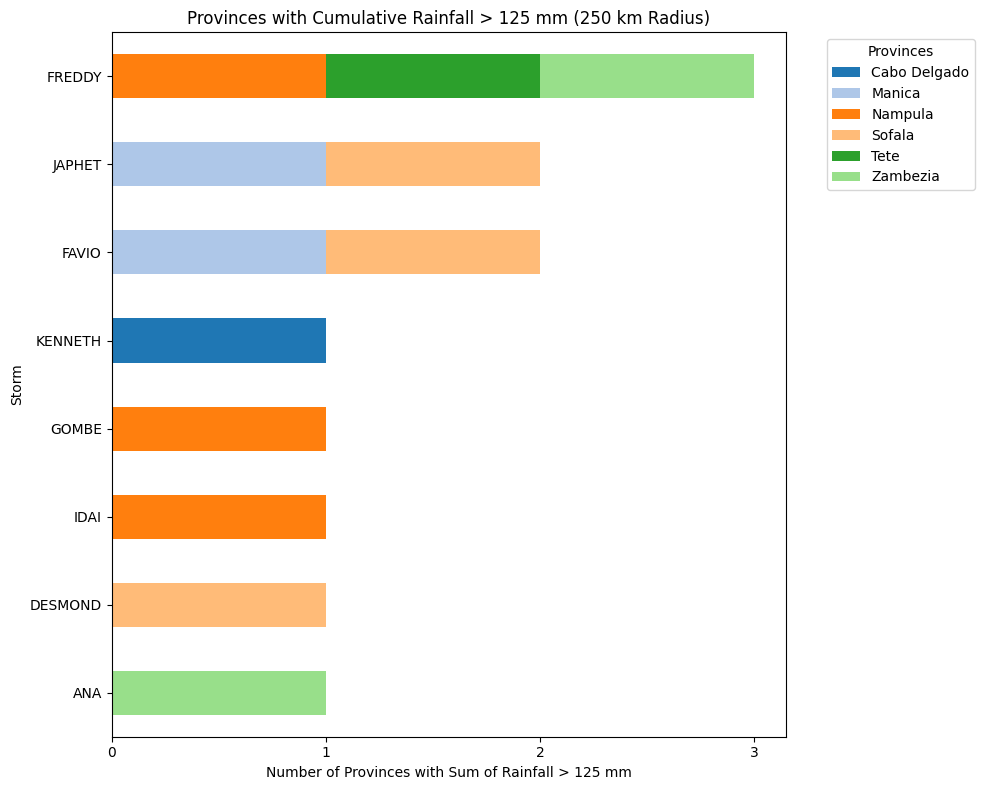

In [24]:
# Filter for radius 250 km and relevant time steps (-1, 0, 1)
df_filtered = rain_df[
    (rain_df["radius"] == 250) & (rain_df["time_step"].isin([-1, 0, 1]))
]

# Group by storm and province to sum the median_precip values across time steps
storm_province_sum = (
    df_filtered.groupby(["storm", "province"])["median_precip"]
    .sum()
    .reset_index()
)

# Filter for provinces where the sum of median_precip > 50
df_above_50 = storm_province_sum[
    storm_province_sum["median_precip"] > threshold
]

# Pivot data for stacked bar chart (count of provinces per storm)
storm_pivot = (
    df_above_50.groupby(["storm", "province"]).size().unstack(fill_value=0)
)

# Add a column for the total count of provinces exceeding 50 mm per storm
storm_pivot["total"] = storm_pivot.sum(axis=1)

# Sort by the total count in ascending order
storm_pivot = storm_pivot.sort_values(by="total", ascending=True).drop(
    columns=["total"]
)

# Assign unique colors to each province
unique_provinces = storm_pivot.columns
colors = cm.tab20.colors[
    : len(unique_provinces)
]  # Use a colormap for distinct province colors
province_color_map = dict(zip(unique_provinces, colors))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Stacked bar chart with storms on the y-axis
storm_pivot.plot(
    kind="barh",
    stacked=True,
    ax=ax,
    color=[province_color_map[province] for province in unique_provinces],
)

# X-axis ticks as integers
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Labels and title
ax.set_ylabel("Storm")
ax.set_xlabel(f"Number of Provinces with Sum of Rainfall > {threshold} mm")
ax.set_title(
    f"Provinces with Cumulative Rainfall > {threshold} mm (250 km Radius)"
)

# Legend for provinces
ax.legend(
    title="Provinces",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    labels=unique_provinces,
)

# Adjust layout
plt.tight_layout()
plt.show()